In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import datetime

data_part = pd.read_csv('airbnb_data.csv')



In [5]:
#Data Exploration and Preprocessing
data_part.head()
data_part.info()
data_part.describe()
data_part.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13251 entries, 0 to 13250
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      13251 non-null  int64  
 1   log_price               13251 non-null  float64
 2   property_type           13251 non-null  object 
 3   room_type               13251 non-null  object 
 4   amenities               13251 non-null  object 
 5   accommodates            13250 non-null  float64
 6   bathrooms               13210 non-null  float64
 7   bed_type                13250 non-null  object 
 8   cancellation_policy     13250 non-null  object 
 9   cleaning_fee            13250 non-null  object 
 10  city                    13250 non-null  object 
 11  description             13250 non-null  object 
 12  first_review            10418 non-null  object 
 13  host_has_profile_pic    13214 non-null  object 
 14  host_identity_verified  13214 non-null

,0
id,0
log_price,0
property_type,0
room_type,0
amenities,0
accommodates,1
bathrooms,41
bed_type,1
cancellation_policy,1
cleaning_fee,1


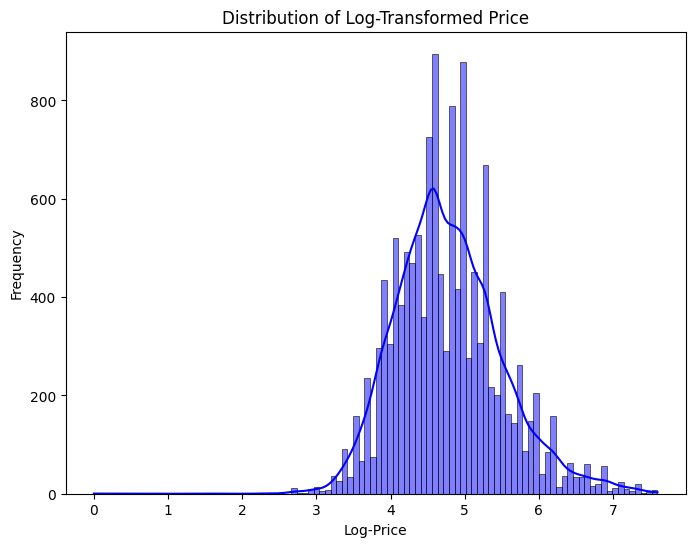

In [6]:
# Plot distribution of log_price
plt.figure(figsize=(8, 6))
sns.histplot(data_part['log_price'], kde=True, color='blue')
plt.title('Distribution of Log-Transformed Price')
plt.xlabel('Log-Price')
plt.ylabel('Frequency')
plt.show()


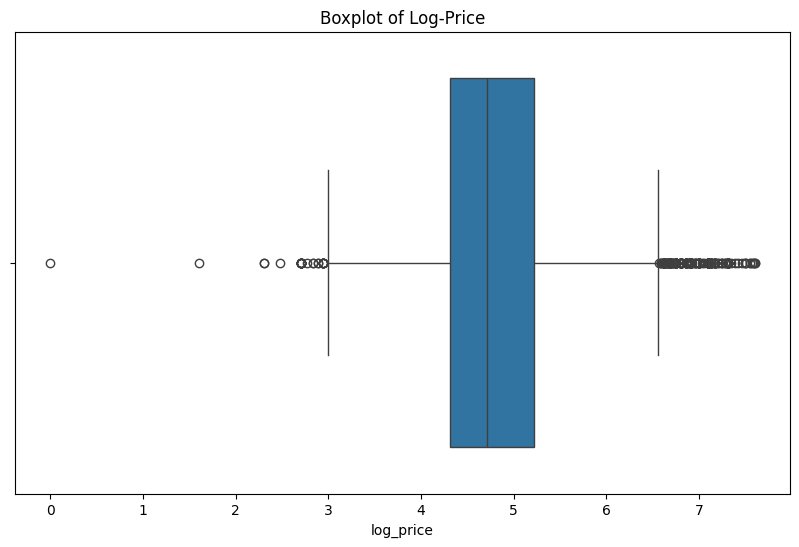

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_part, x='log_price')
plt.title('Boxplot of Log-Price')
plt.show()

In [8]:
# Convert date columns to datetime format
data_part['first_review'] = pd.to_datetime(data_part['first_review'], errors='coerce')
data_part['last_review'] = pd.to_datetime(data_part['last_review'], errors='coerce')

data_part['first_review_year'] = data_part['first_review'].dt.year
data_part['last_review_year'] = data_part['last_review'].dt.year
data_part['first_review_month'] = data_part['first_review'].dt.month
data_part['last_review_month'] = data_part['last_review'].dt.month


<ipython-input-8-946831202d27>:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_part['first_review'] = pd.to_datetime(data_part['first_review'], errors='coerce')
<ipython-input-8-946831202d27>:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_part['last_review'] = pd.to_datetime(data_part['last_review'], errors='coerce')


In [11]:
data_encoded = pd.get_dummies(data_part, columns=['property_type', 'room_type', 'bed_type', 'cancellation_policy',
                                             'city', 'neighbourhood'], drop_first=True)


In [12]:
# Final check for missing values
data_encoded.info()
data_encoded.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13251 entries, 0 to 13250
Columns: 577 entries, id to neighbourhood_Wrigleyville
dtypes: bool(550), datetime64[ns](2), float64(13), int64(1), object(11)
memory usage: 9.7+ MB


,0
id,0
log_price,0
amenities,0
accommodates,1
bathrooms,41
...,...
neighbourhood_Woodlawn,0
neighbourhood_Woodley Park,0
neighbourhood_Woodridge,0
neighbourhood_Woodside,0


In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Clean 'zipcode'
data_encoded['zipcode'] = data_encoded['zipcode'].astype(str).str.extract(r'(\d{5})')
data_encoded['zipcode'] = pd.to_numeric(data_encoded['zipcode'], errors='coerce')

numerical_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds',
                      'number_of_reviews', 'review_scores_rating',
                      'latitude', 'longitude', 'zipcode']

data_encoded.dropna(subset=numerical_features, inplace=True)

scaler = StandardScaler()
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])


In [ ]:
# In above codes

# Handled Missing Values: Filled missing values for numerical and categorical features.

# Detected and Handled Outliers: Used boxplots and IQR to remove extreme values.

# Feature Engineering: Created new features like year and month from review dates and performed one-hot encoding for categorical variables.

# Scaled Numerical Features: Used scaling to standardize the numerical features.

In [19]:
#Model Devolpment
df = pd.read_csv('airbnb_data.csv')

df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce', dayfirst=True)
df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce', dayfirst=True)
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce', dayfirst=True)

# Create host experience feature
df['host_experience_days'] = (pd.to_datetime('today') - df['host_since']).dt.days

# Clean host_response_rate
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float) / 100

# Convert booleans
bool_cols = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
for col in bool_cols:
    df[col] = df[col].astype(str).map({'t': 1, 'f': 0, 'TRUE': 1, 'FALSE': 0})

# Count number of amenities
df['num_amenities'] = df['amenities'].apply(lambda x: len(x.strip('{}').split(',')) if pd.notnull(x) else 0)

features = [
    'property_type', 'room_type', 'accommodates', 'bathrooms', 'bed_type',
    'cancellation_policy', 'cleaning_fee', 'city', 'host_response_rate',
    'instant_bookable', 'review_scores_rating', 'number_of_reviews',
    'latitude', 'longitude', 'bedrooms', 'beds', 'num_amenities', 'host_experience_days'
]
target = 'log_price'

df_model = df[features + [target]].dropna(subset=[target])

X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


numeric_features = [
    'accommodates', 'bathrooms', 'cleaning_fee', 'host_response_rate',
    'instant_bookable', 'review_scores_rating', 'number_of_reviews',
    'latitude', 'longitude', 'bedrooms', 'beds', 'num_amenities', 'host_experience_days'
]

categorical_features = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

# Step 6: Evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse:.4f}')


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['cleaning_fee']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Root Mean Squared Error: 0.4238


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['cleaning_fee']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


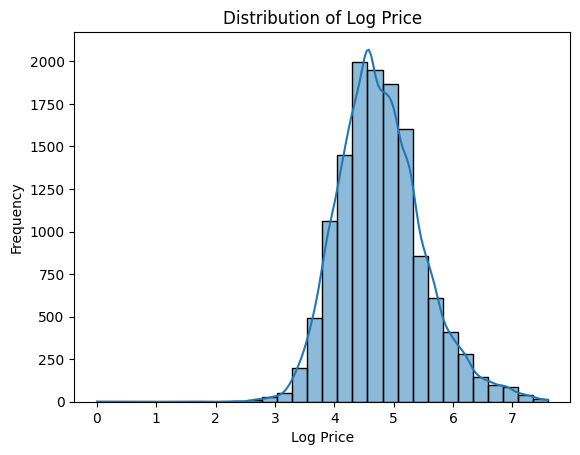

In [22]:
#checking model with visualizations
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['log_price'], bins=30, kde=True)
plt.title('Distribution of Log Price')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()


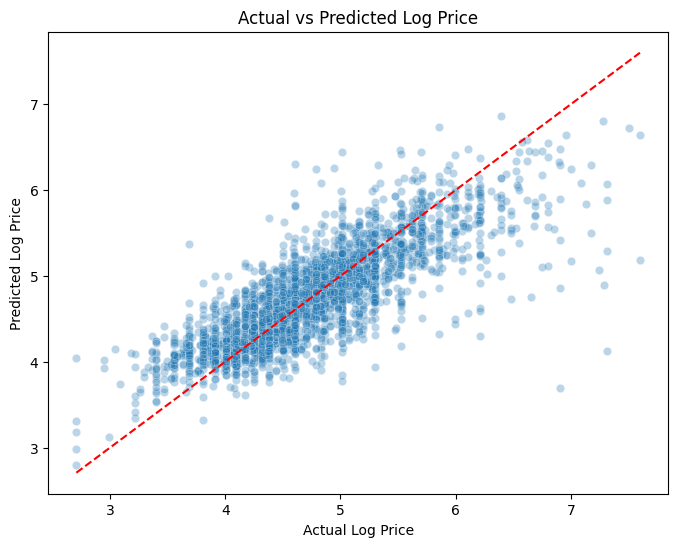

In [25]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonal line
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')
plt.title('Actual vs Predicted Log Price')
plt.show()


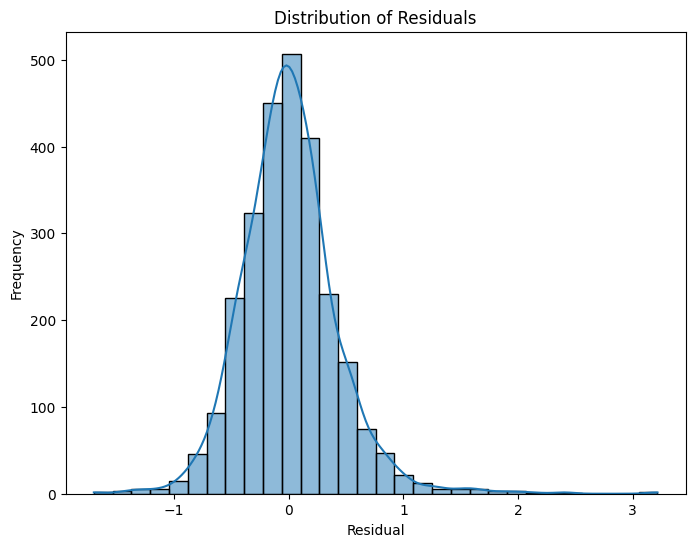

In [26]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Task 3 Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.3087
Root Mean Squared Error (RMSE): 0.4238
R-squared (R²): 0.6449
